In [1]:
import plotly.express as px
import numpy as np
import random
from scipy import optimize

import scipy

In [111]:
scipy.__version__, nx.__version__

('1.4.1', '2.5.1')

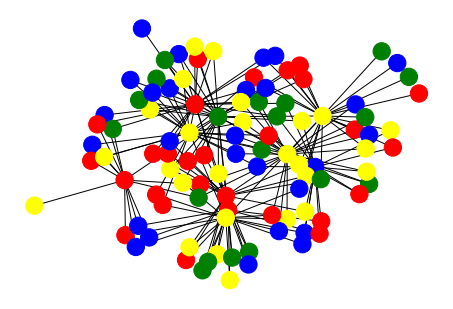

In [3]:
n_nodes = 100

import networkx as nx
import matplotlib.pyplot as plt

kcolors = ['red', 'green', 'blue', 'yellow']
color_to_bin = {'red': 1, 'green': 0, 'blue': 2, 'yellow': 3}

random_edges = {}
degrees = {}
for i in range(n_nodes):
    random_edges[i] = []
    if i not in degrees:
        degrees[i] = 0
    for _ in range(2):
        conn_node = random.sample(range(10), 1)[0]
        if conn_node not in degrees:
            degrees[conn_node] = 0
        if conn_node != i and conn_node not in random_edges[i]:
            random_edges[i].append(conn_node)
            degrees[i] += 1
            degrees[conn_node] += 1
            
G = nx.Graph(random_edges)
colors = []
init_colors = []
for n in G.nodes():
    curr_color = random.sample(kcolors, 1)[0]
    colors.append(curr_color)
    init_colors.append(color_to_bin[curr_color])

nx.draw(G, node_color=colors)
plt.show()

In [4]:
def get_fitness_kcolors(color_state):
    fitness = 0
    for edge in G.edges():
        if color_state[edge[0]] != color_state[edge[1]]:
            fitness+= 1
    return fitness
get_fitness_kcolors(init_colors)

144

In [11]:
import mlrose_hiive
import time

In [30]:
restarts = [0, 10, 100, 1000]
restart_curves = []
for res in restarts:
    kcolor_fitness = mlrose_hiive.fitness.MaxKColor(G.edges())
    opt = mlrose_hiive.MaxKColorOpt(edges=G.edges(), length=n_nodes, fitness_fn=kcolor_fitness, maximize=True, max_colors=4)
    start = time.time()
    opt_sol, opt_val, curr_fitness = mlrose_hiive.algorithms.random_hill_climb(
          opt, max_attempts=10, max_iters=100, restarts=res,
          init_state=None, curve=True, random_state=None,
          state_fitness_callback=None, callback_user_info=None
    )
    end = time.time()
    restart_curves.append((res, opt_sol, opt_val, curr_fitness, end-start))

In [98]:
decays = [('geometric', mlrose_hiive.algorithms.decay.GeomDecay(init_temp=1.0, decay=0.99, min_temp=0.001)),
          ('arithmetic', mlrose_hiive.algorithms.decay.ArithDecay(init_temp=1.0, decay=0.99, min_temp=0.001)),
          ('exponential', mlrose_hiive.algorithms.decay.ExpDecay(init_temp=1.0, exp_const=0.005, min_temp=0.001))]
decay_curves = []
for dec in decays:
    kcolor_fitness = mlrose_hiive.fitness.MaxKColor(G.edges())
    opt = mlrose_hiive.MaxKColorOpt(edges=G.edges(), length=n_nodes, fitness_fn=kcolor_fitness, maximize=True, max_colors=4)
    start = time.time()
    opt_sol, opt_val, curr_fitness = mlrose_hiive.algorithms.simulated_annealing(
        opt, schedule=dec[1],
        max_attempts=10, max_iters=1000, init_state=None, curve=True,
        fevals=False, random_state=None,
        state_fitness_callback=None, callback_user_info=None
    )
    end = time.time()
    decay_curves.append((dec[0], opt_sol, opt_val, curr_fitness, end-start))

In [22]:
pop_percent = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
percent_curves = []

for perc in pop_percent:
    kcolor_fitness = mlrose_hiive.fitness.MaxKColor(G.edges())
    opt = mlrose_hiive.MaxKColorOpt(edges=G.edges(), length=n_nodes, fitness_fn=kcolor_fitness, maximize=True, max_colors=4)
    start = time.time()
    opt_sol, opt_val, curr_fitness = mlrose_hiive.algorithms.genetic_alg(
        opt, pop_size=len(G.nodes()), pop_breed_percent=perc, elite_dreg_ratio=0.95,
        minimum_elites=0, minimum_dregs=0, mutation_prob=0.1,
        max_attempts=10, max_iters=100, curve=True, random_state=None
    )
    end = time.time()
    percent_curves.append((perc, opt_sol, opt_val, curr_fitness, end-start))

In [108]:
keep_percent = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
keep_curves = []
for perc in keep_percent:
    print(perc)
    kcolor_fitness = mlrose_hiive.fitness.MaxKColor(G.edges())
    opt = mlrose_hiive.MaxKColorOpt(edges=G.edges(), length=n_nodes, fitness_fn=kcolor_fitness, maximize=True, max_colors=4)
    start = time.time()
    opt_sol, opt_val, curr_fitness = mlrose_hiive.algorithms.mimic(
        opt, pop_size=len(G.nodes()), keep_pct=perc, max_attempts=10,
        max_iters=100, curve=True, random_state=None,
        state_fitness_callback=None, callback_user_info=None, noise=0.0
    )
    end = time.time()
    keep_curves.append((perc, opt_sol, opt_val, curr_fitness, end-start))

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0


In [38]:
import pandas as pd
rhc_df = pd.DataFrame(
    [('RHC', curve_tuples[-1], curve_tuples[0], elem[0], elem[1], idx) for curve_tuples in restart_curves for idx, elem in enumerate(curve_tuples[3])],
    columns=['Algorithm', 'Time', 'Restarts', 'Fitness Value', 'Fitness Evaluations', 'Iteration']
)
sa_df = pd.DataFrame(
    [('SA', curve_tuples[-1], curve_tuples[0], elem[0], elem[1], idx) for curve_tuples in decay_curves for idx, elem in enumerate(curve_tuples[3])],
    columns=['Algorithm', 'Time', 'Decay Type', 'Fitness Value', 'Fitness Evaluations', 'Iteration']
)
ga_df = pd.DataFrame(
    [('GA', curve_tuples[-1], curve_tuples[0], elem[0], elem[1], idx) for curve_tuples in percent_curves for idx, elem in enumerate(curve_tuples[3])],
    columns=['Algorithm', 'Time', 'Breeding Percentage', 'Fitness Value', 'Fitness Evaluations', 'Iteration']
)
mimic_df = pd.DataFrame(
    [('MIMIC', curve_tuples[-1], curve_tuples[0], elem[0], elem[1], idx) for curve_tuples in keep_curves for idx, elem in enumerate(curve_tuples[3])],
    columns=['Algorithm', 'Time', 'Keep Percentage', 'Fitness Value', 'Fitness Evaluations', 'Iteration']
)
fig = px.line(rhc_df, x='Iteration', y='Fitness Value', color='Restarts', title='RHC Performance in 4-Color with Different Restart Counts')
fig.update_yaxes(range=[120, 190])
fig.update_xaxes(range=[0, 1000])
fig.show()

fig = px.line(sa_df, x='Iteration', y='Fitness Value', color='Decay Type', title='SA Performance in 4-Color with Different Decay Functions')
fig.update_yaxes(range=[120, 190])
fig.update_xaxes(range=[0, 1000])
fig.show()

fig = px.line(ga_df, x='Iteration', y='Fitness Value', color='Breeding Percentage', title='GA Performance in 4-Color with Different Breeding Percentages')
fig.update_yaxes(range=[120, 190])
fig.update_xaxes(range=[0, 1000])
fig.show()

fig = px.line(mimic_df, x='Iteration', y='Fitness Value', color='Keep Percentage', title='MIMIC Performance in 4-Color with Different Keep Percentages')
fig.update_yaxes(range=[120, 190])
fig.update_xaxes(range=[0, 1000])
fig.show()